<a href="https://colab.research.google.com/github/Sidy3143/Reinforcement-Learning/blob/main/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DQN Algorithm on Cartpole environment

In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch] # Q values of te actions taken
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma*T.max(q_next, dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device) # same as loss( q_eval, q_target) for MSE
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

In [ ]:
!pip install gym

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

import gym  # Environment library
import torch as T  # PyTorch for neural networks
import numpy as np  # For handling data
import matplotlib.pyplot as plt  # For plotting performance

# Assuming the Agent class from your code is already defined
# Your DQN Agent class here...

# Create the environment
env = gym.make('CartPole-v1')  # Replace with your preferred environment

n_games = 400  # Number of episodes
scores, eps_history = [], []

# Initialize agent
agent = Agent(gamma=0.99, epsilon=1.0, lr=0.001, input_dims=env.observation_space.shape, batch_size=64, n_actions=env.action_space.n)

# Training loop
for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()  # Start a new episode

    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        agent.store_transition(observation, action, reward, observation_, done)

        agent.learn()

        score += reward
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)

    # Print training progress
    if i % 10 == 0:
        avg_score = np.mean(scores[-10:])
        print(f"Episode {i}, Score: {score}, Avg Score: {avg_score}, Epsilon: {agent.epsilon}")

# Plotting the scores
plt.plot(scores)
plt.title('Training Progress')
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.show()


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Score: 17.0, Avg Score: 17.0, Epsilon: 1.0


<ipython-input-1-1cb17095d05f>:68: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  state = T.tensor([observation]).to(self.Q_eval.device)


Episode 10, Score: 16.0, Avg Score: 16.2, Epsilon: 0.9420000000000064
Episode 20, Score: 19.0, Avg Score: 26.9, Epsilon: 0.8075000000000212
Episode 30, Score: 30.0, Avg Score: 23.4, Epsilon: 0.6905000000000341
Episode 40, Score: 54.0, Avg Score: 35.0, Epsilon: 0.5155000000000534
Episode 50, Score: 165.0, Avg Score: 88.6, Epsilon: 0.07250000000005469
Episode 60, Score: 304.0, Avg Score: 220.7, Epsilon: 0.05
Episode 70, Score: 132.0, Avg Score: 256.8, Epsilon: 0.05
Episode 80, Score: 222.0, Avg Score: 265.5, Epsilon: 0.05
Episode 90, Score: 211.0, Avg Score: 310.8, Epsilon: 0.05
Episode 100, Score: 216.0, Avg Score: 296.7, Epsilon: 0.05


KeyboardInterrupt: 

In [ ]:
T.save(agent.Q_eval.state_dict(), 'trained_agent_cartpole.pth')

In [ ]:
!pip install pyvirtualdisplay

In [ ]:
!apt-get update
!apt-get install -y xvfb # Install xvfb

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,164 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,466 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Package

In [ ]:
device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
agent.Q_eval.load_state_dict(T.load('trained_agent_cartpole.pth'))
agent.Q_eval.eval()  # Set the model to evaluation mode

<ipython-input-36-7b54b3ee99b7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.Q_eval.load_state_dict(T.load('trained_agent_cartpole.pth'))


DeepQNetwork(
  (fc1): Linear(in_features=4, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (loss): MSELoss()
)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecat

Episode 1: Reward = 156.0
Episode 2: Reward = 318.0
Episode 3: Reward = 167.0
Episode 4: Reward = 154.0
Episode 5: Reward = 209.0

Average Reward over 5 episodes: 200.8


/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


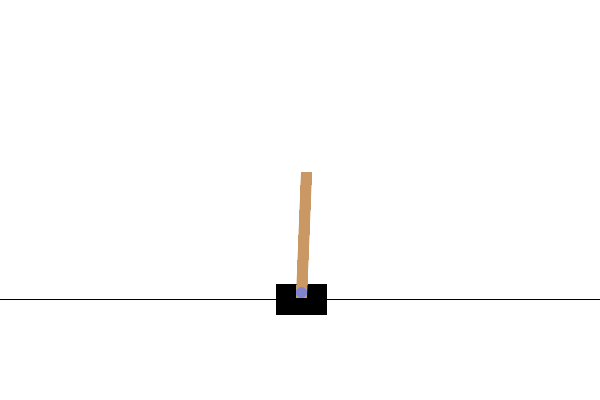

In [ ]:
#test
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

import gym
env = gym.make("CartPole-v1")
observation = env.reset()

def show_frame(frame):
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

def agent_action(model, observation, current_score):
    observation = T.tensor(observation, dtype=T.float32).unsqueeze(0).to(device)
    with T.no_grad():
        action_prob = model.Q_eval(observation)
    action = T.argmax(action_prob).item()

    return action

scores = []
all_frames = []
for i in range(5):
    frames = []
    done = False
    score = 0
    observation = env.reset()
    while not done:
        frame = env.render(mode='rgb_array')  # Capturer la frame
        frames.append(frame)

        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        observation = observation_

    print(f"Episode {i + 1}: Reward = {score}")
    scores.append(score)
    all_frames.extend(frames)
env.close()

avg_reward = sum(scores) / 5
print(f"\nAverage Reward over {5} episodes: {avg_reward}")

# Save all frames as a single GIF
imageio.mimsave('/content/trained_agent_cartpole_all_episodes.gif', all_frames, fps=30)

# Afficher le GIF
from IPython.display import Image
Image(filename='/content/trained_agent_cartpole_all_episodes.gif')

In [ ]:
agent.epsilon

0.05

In [ ]:
import gym
import torch as T

# Assuming your Agent and DeepQNetwork classes are defined

# Load the trained model
agent = Agent(gamma=0.99, epsilon=0.1, lr=0.0001,  # Set epsilon to 0 for testing
              input_dims=env.observation_space.shape,
              batch_size=64, n_actions=env.action_space.n)

agent.Q_eval.load_state_dict(T.load('trained_agent_cartpole.pth'))
agent.Q_eval.eval()  # Set the model to evaluation mode

# Create the environment
env = gym.make('CartPole-v1')

# Number of test episodes
num_episodes = 4

# Testing loop
total_rewards = []
for episode in range(num_episodes):
    observation = env.reset()
    done = False
    episode_reward = 0

    while not done:
        # Choose action using the trained model
        action = agent.choose_action(observation)

        # Take the action in the environment
        observation_, reward, done, info = env.step(action)

        # Update episode reward
        episode_reward += reward

        # Update observation
        observation = observation_

    total_rewards.append(episode_reward)
    print(f"Episode {episode + 1}: Reward = {episode_reward}")

# Calculate and print average reward
avg_reward = sum(total_rewards) / num_episodes
print(f"\nAverage Reward over {num_episodes} episodes: {avg_reward}")

env.close()

<ipython-input-25-09322475cc1c>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.Q_eval.load_state_dict(T.load('trained_agent_cartpole.pth'))


Episode 1: Reward = 141.0
Episode 2: Reward = 223.0
Episode 3: Reward = 500.0
Episode 4: Reward = 260.0

Average Reward over 4 episodes: 281.0
